In [440]:
import networkx as nx
import pandas as pd
import json

from matplotlib import pyplot as plt
from collections.abc import Mapping
from typing import Any, Literal
from itertools import product
from pathlib import Path

import numpy as np
from collections import Counter

In [441]:
def parse_results(path: str) -> pd.DataFrame:
    records = []
    with open(path, 'r') as f:
        buffer = []
        depth = 0

        for raw in f:
            line = raw.strip()
            if not line:
                continue  # skip blank lines

            # Track nesting of braces
            depth += line.count('{')
            depth -= line.count('}')

            buffer.append(raw)
            # If we’ve closed all opened braces, process one full JSON object
            if depth == 0 and buffer:
                chunk = ''.join(buffer)
                obj = json.loads(chunk)
                # same flattening logic as before
                for uid, details in obj.items():
                    params = details.pop('params')
                    flat = {'id': uid, **details}
                    for p, v in params.items():
                        if isinstance(v, list) and len(v) == 2:
                            flat[f'{p}_x'] = v[0]
                            flat[f'{p}_y'] = v[1]
                        else:
                            flat[p] = v
                    records.append(flat)
                buffer = []
    return pd.DataFrame(records)

In [442]:
path = "results/"
file_name = "result_PolyHoot_ST_1_1a375432-5c13-4b1c-82b2-49317b32a699.jsonl"
df = parse_results(path + file_name)

In [443]:
df.head()

,id,score,total_ghosts,overall_ghost_rate,event_avg_ghost_rate,clone_percentage,total_tracks,time,scatter,min_strong_track_length,allowed_missed_modules
0,c1d6f3d8-47ce-445a-9656-91ad5a5bcf66,28506.868910,26608,46.707743,40.157908,2.706808,56967,1.503873,NaN,NaN,NaN
1,d244bd85-c576-4149-9493-056a18e07823,24813.411227,18751,37.812821,31.566518,2.991946,49589,0.481621,0.25,10.0,2.0
2,ae98d4ee-d014-40fa-a5b5-68d1c8e4d43d,30400.524109,31006,51.038683,44.848585,2.616575,60750,0.476730,0.75,10.0,2.0
3,2554e2ec-8474-4fb0-8e9e-e630aa69132b,18656.823421,6578,17.637280,15.141903,2.833539,37296,0.478080,0.25,5.0,2.0
4,00fb3090-876c-48de-88de-872160cd9c14,25869.147125,20827,40.285891,33.853641,3.000829,51698,0.417927,0.25,15.0,2.0


In [444]:
def plot_convergence(
    df,
    figsize=(8, 5),
    title_fontsize=18,
    label_fontsize=14,
    tick_fontsize=12,
    dpi=300,
    color="#4C4C4C",
    linestyle="-",
    linewidth=1.5
):
    # 1) Configure rcParams
    plt.rcParams.update({
        "font.family":       "serif",
        "font.serif":        ["Times New Roman", "Palatino", "serif"],
        "axes.titlesize":    title_fontsize,
        "axes.labelsize":    label_fontsize,
        "xtick.labelsize":   tick_fontsize,
        "ytick.labelsize":   tick_fontsize,
        "figure.dpi":        dpi,
        "axes.linewidth":    1.0,
        "xtick.major.size":  5,
        "ytick.major.size":  5,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "axes.grid":         True,
        "grid.color":        "#999999",
        "grid.alpha":        0.2,
        "grid.linestyle":    "--"
    })

    # 2) Plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(
        df.index,
        df['score'],
        color=color,
        linestyle=linestyle,
        linewidth=linewidth
    )
    ax.set_title("Convergence", pad=10)
    ax.set_xlabel("Iterations", fontsize=label_fontsize)
    ax.set_ylabel("Score", fontsize=label_fontsize)
    ax.grid(True)  # already styled via rcParams

    plt.tight_layout()
    plt.show()

In [445]:
def plot_convergence_with_hyperparam(
    full_df,
    hyperparam_names,
    score_col='score',
    figsize=(10, 8),
    title_fontsize=18,
    label_fontsize=14,
    tick_fontsize=12,
    dpi=300,
    color="#4C4C4C",
    linestyle="-",
    linewidth=1.5,
    title="TITLE",
    title_panel="TITLE",
    annotate_threshold=0.2
):
    import matplotlib.pyplot as plt
    import numpy as np
    from collections import Counter

    # Configure rcParams
    plt.rcParams.update({
        "font.family":       "serif",
        "font.serif":        ["Times New Roman", "Palatino", "serif"],
        "axes.titlesize":    title_fontsize,
        "axes.labelsize":    label_fontsize,
        "xtick.labelsize":   tick_fontsize,
        "ytick.labelsize":   tick_fontsize,
        "figure.dpi":        dpi,
        "axes.linewidth":    1.0,
        "xtick.major.size":  5,
        "ytick.major.size":  5,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "axes.grid":         True,
        "grid.color":        "#999999",
        "grid.alpha":        0.2,
        "grid.linestyle":    "--"
    })

    # Extract score and hyperparameter combinations
    scores = full_df[score_col].reset_index(drop=True)
    hp_combos = full_df[hyperparam_names].astype(str).agg(tuple, axis=1).tolist()

    # Encode combinations as short labels
    unique_combos = sorted(set(hp_combos))
    combo_labels = {combo: f"C{i+1}" for i, combo in enumerate(unique_combos)}
    labeled_combos = [combo_labels[c] for c in hp_combos]

    # Invert for lookup later
    label_to_combo = {v: k for k, v in combo_labels.items()}

    iterations = list(range(1, len(scores) + 1))
    categories = list(combo_labels.values())

    # Compute cumulative frequencies
    frequencies = {cat: [] for cat in categories}
    for i in range(1, len(labeled_combos) + 1):
        count = Counter(labeled_combos[:i])
        total = i
        for cat in categories:
            frequencies[cat].append(count[cat] / total)

    data = np.vstack([frequencies[cat] for cat in categories])

    # Plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True, height_ratios=[2, 1])

    # Top Panel: Score convergence
    ax1.plot(iterations, scores, color=color, linestyle=linestyle, linewidth=linewidth)
    ax1.set_title(title, pad=10)
    ax1.set_ylabel("Score")
    ax1.grid(True)

    # Bottom Panel: Stacked area plot
    ax2.stackplot(iterations, data, labels=categories, alpha=0.8)
    ax2.set_ylabel("Proportion")
    ax2.set_title(title_panel)
    ax2.set_xlabel("Iteration")
    ax2.set_ylim(0, 1)
    ax2.grid(True)

    # Annotate and print combos > threshold
    final_props = data[:, -1]
    print(f"\nHyperparameter combinations with >{int(annotate_threshold*100)}% share at final iteration:\n")

    for i, prop in enumerate(final_props):
        if prop > annotate_threshold:
            y_position = sum(data[j, -1] for j in range(i)) + prop / 2
            label = categories[i]
            combo = label_to_combo[label]
            ax2.text(
                x=iterations[-1] + 10,
                y=y_position,
                s=label,
                fontsize=label_fontsize * 0.75,
                va='center'
            )
            combo_str = ", ".join(f"{name}={value}" for name, value in zip(hyperparam_names, combo))
            print(f"{label}: {combo_str}")


    plt.tight_layout()
    plt.show()



Hyperparameter combinations with >10% share at final iteration:

C1: scatter=0.0078125, min_strong_track_length=5.0, allowed_missed_modules=4.0
C2: scatter=0.015625, min_strong_track_length=5.0, allowed_missed_modules=4.0


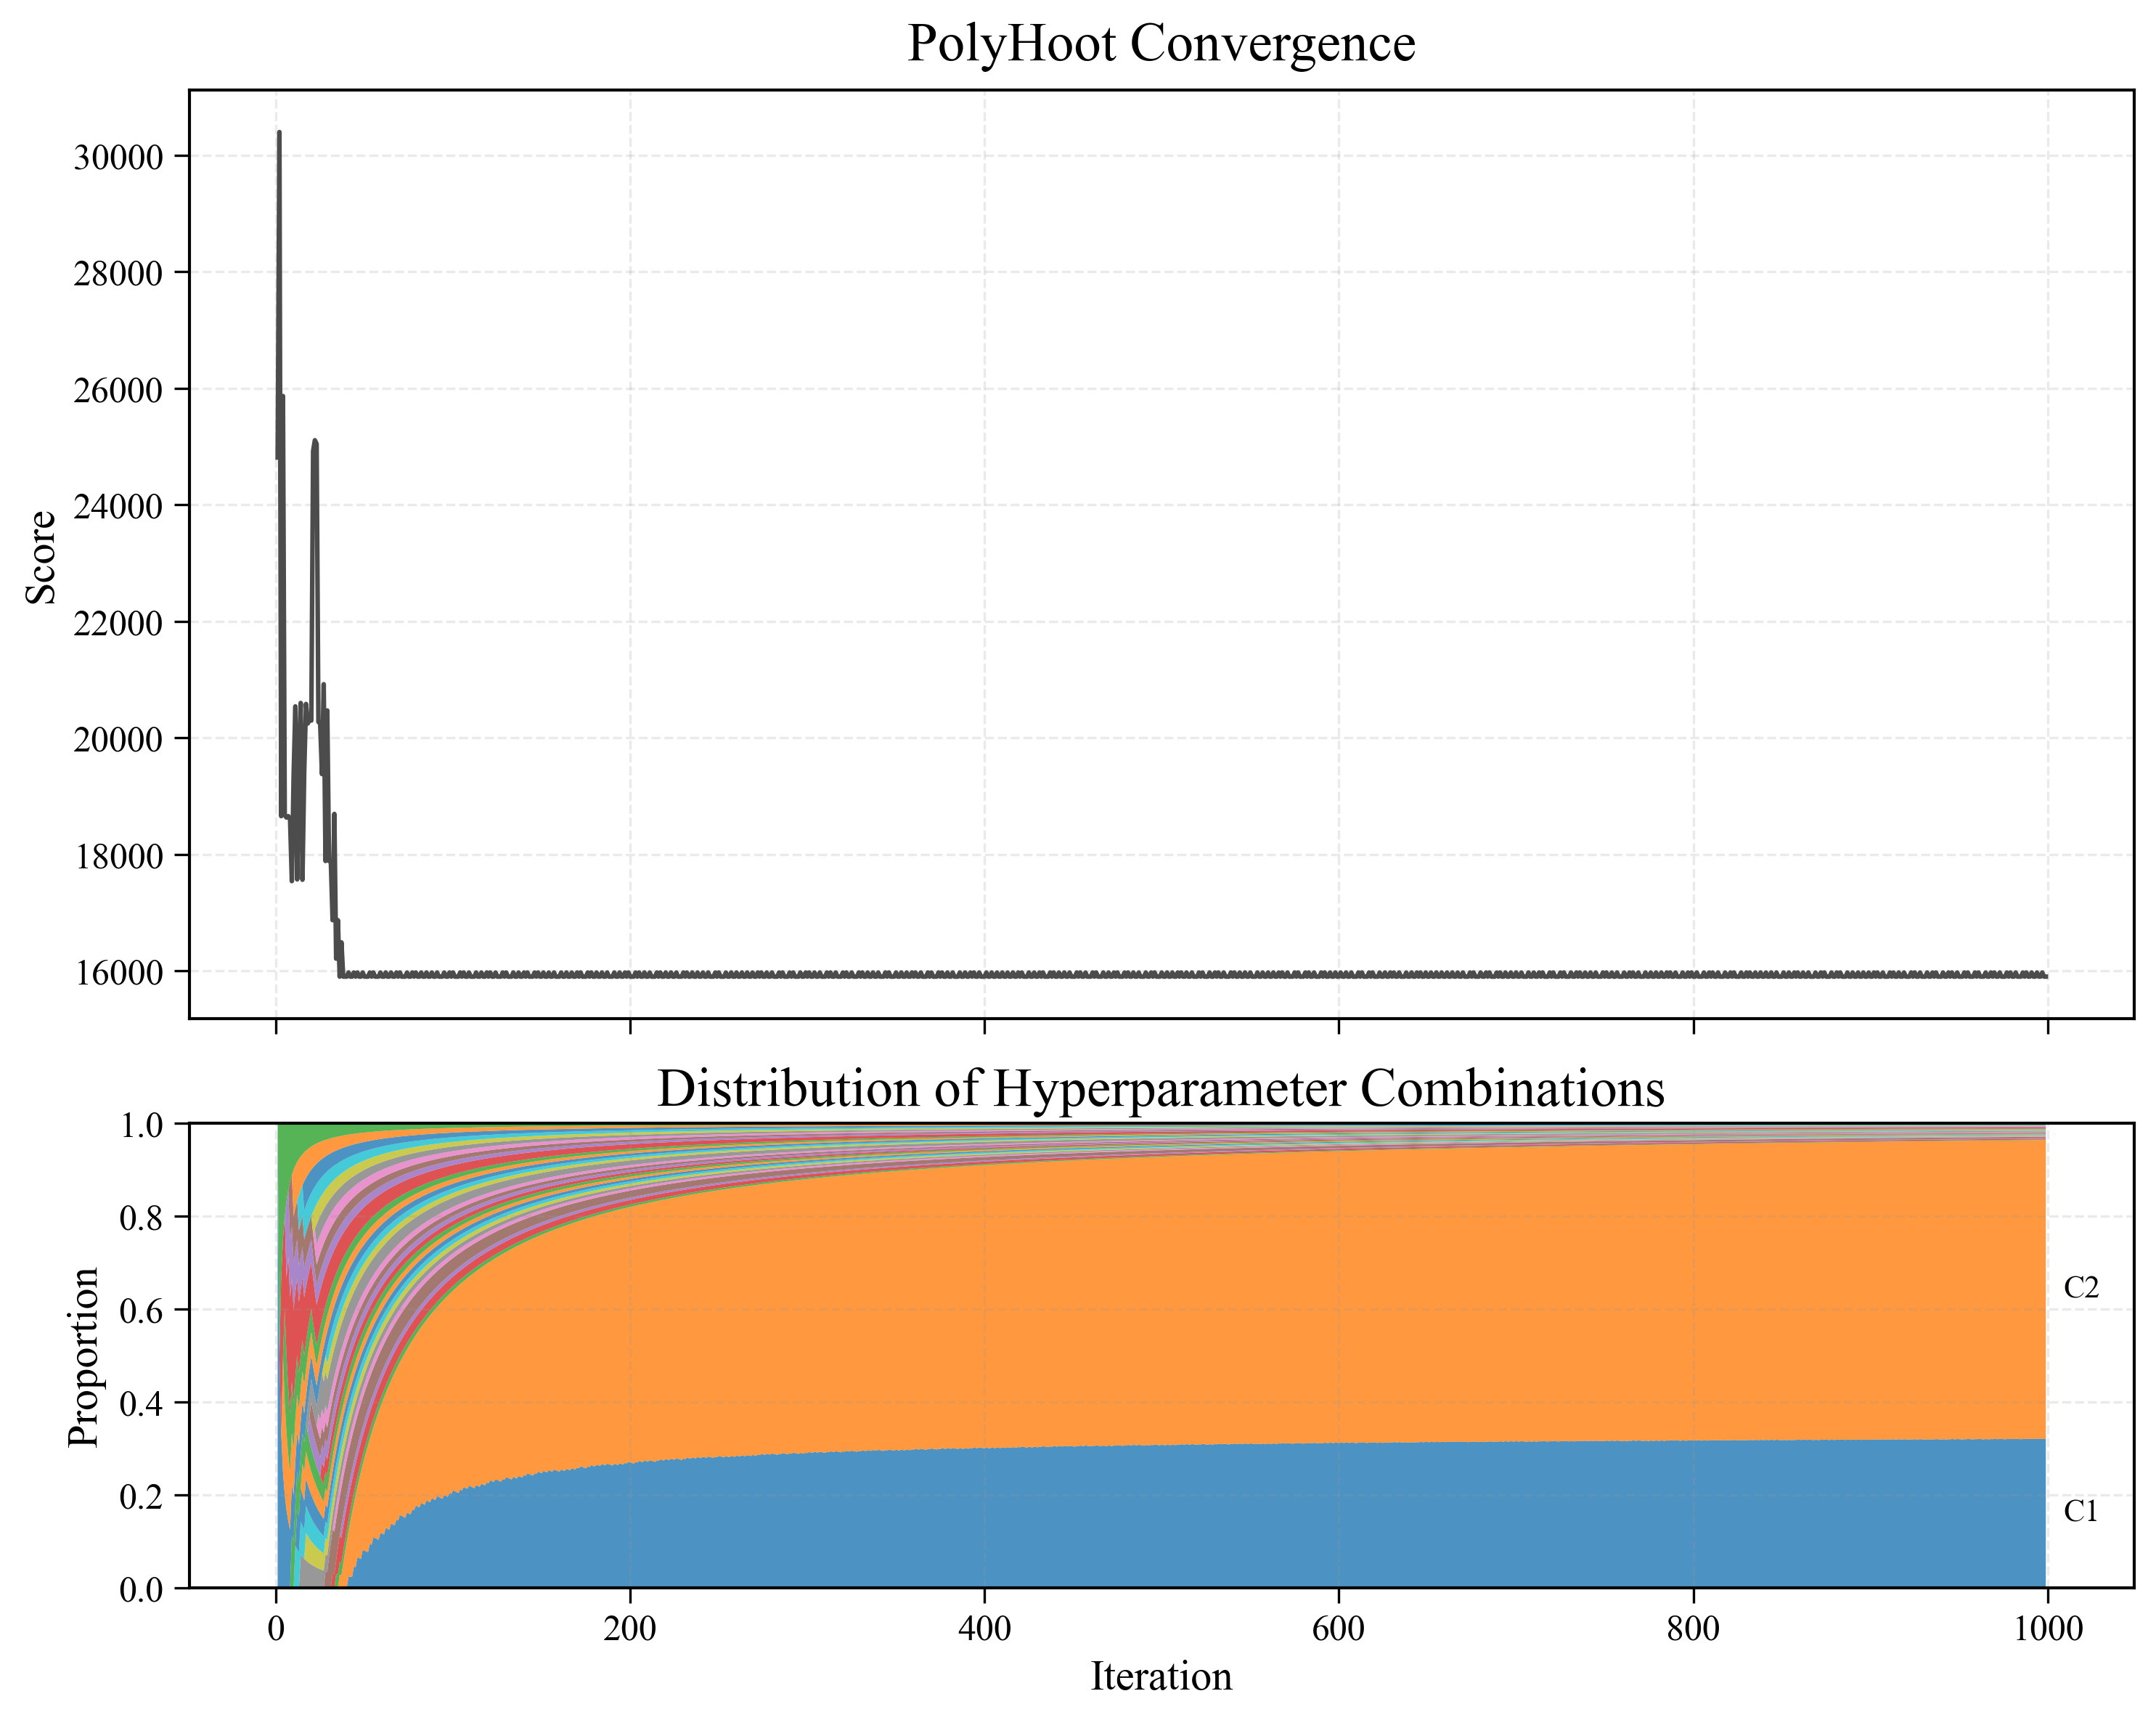

In [446]:

plot_convergence_with_hyperparam(
    df.dropna(), 
    hyperparam_names=['scatter', 'min_strong_track_length', 'allowed_missed_modules'],
    title="PolyHoot Convergence",
    title_panel="Distribution of Hyperparameter Combinations",
    annotate_threshold=0.1
    )



## NOW lets do it for multiple itterations

In [447]:
def get_config(file_path: str):
    stem = Path(file_path).stem            
    config_name = stem.removeprefix("result_")      
    
    config_path = Path("configurations") / f"{config_name}.json"
    
    # 3) Open & load the JSON
    with config_path.open("r", encoding="utf-8") as f:
        config = json.load(f)
    return config

In [448]:
def plot_multiple(
    full_df,
    hyperparam_names,
    score_col='score',
    config_col='config',
    figsize=(10, 8),
    title_fontsize=18,
    label_fontsize=14,
    tick_fontsize=12,
    dpi=300,
    color="#4C4C4C",
    linestyle="-",
    linewidth=1.5,
    title="Score Convergence per Experiment",
    title_panel="Aggregate Hyperparameter Combinations",
    annotate_threshold=0.2,
    xlim=1000
):
    import matplotlib.pyplot as plt
    import numpy as np
    from collections import Counter

    # Configure rcParams
    plt.rcParams.update({
        "font.family":       "serif",
        "font.serif":        ["Times New Roman", "Palatino", "serif"],
        "axes.titlesize":    title_fontsize,
        "axes.labelsize":    label_fontsize,
        "xtick.labelsize":   tick_fontsize,
        "ytick.labelsize":   tick_fontsize,
        "figure.dpi":        dpi,
        "axes.linewidth":    1.0,
        "xtick.major.size":  5,
        "ytick.major.size":  5,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "axes.grid":         True,
        "grid.color":        "#999999",
        "grid.alpha":        0.2,
        "grid.linestyle":    "--"
    })

    # --- Prepare hyperparameter combo labels (all data)
    hp_combos = full_df[hyperparam_names].astype(str).agg(tuple, axis=1).tolist()
    unique_combos = sorted(set(hp_combos))
    combo_labels = {combo: f"C{i+1}" for i, combo in enumerate(unique_combos)}
    labeled_combos = [combo_labels[c] for c in hp_combos]
    label_to_combo = {v: k for k, v in combo_labels.items()}

    full_df = full_df.copy()
    full_df['combo_label'] = labeled_combos

    # --- Prepare plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=False, height_ratios=[2, 1])

    # === TOP PANEL: Score per config
    configs = full_df[config_col].unique()
    for cfg in configs:
        cfg_df = full_df[full_df[config_col] == cfg].sort_index()
        ax1.plot(
            range(1, len(cfg_df) + 1),
            cfg_df[score_col],
            label=cfg,
            linewidth=linewidth,
            linestyle=linestyle
        )

    labels = [f"Run {i+1}" for i in range(len(configs))]
    ax1.set_title(title, pad=10)
    ax1.set_ylabel("Score")
    ax1.legend(labels=labels, loc='best', fontsize=label_fontsize * 0.7)
    ax1.set_xlim(0, xlim)
    ax1.grid(True)

    # === BOTTOM PANEL: Aggregate combo proportions
    labeled_combos_all = full_df['combo_label'].tolist()
    iterations = list(range(1, len(labeled_combos_all) + 1))
    categories = list(combo_labels.values())

    # Compute cumulative frequencies
    frequencies = {cat: [] for cat in categories}
    for i in range(1, len(labeled_combos_all) + 1):
        count = Counter(labeled_combos_all[:i])
        total = i
        for cat in categories:
            frequencies[cat].append(count[cat] / total)

    data = np.vstack([frequencies[cat] for cat in categories])

    # Plot stacked area
    ax2.stackplot(iterations, data, labels=categories, alpha=0.8)
    ax2.set_ylabel("Proportion")
    ax2.set_title(title_panel)
    ax2.set_xlabel("Iteration")
    ax2.set_ylim(0, 1)
    ax2.grid(True)

    # Annotate final dominant combos
    final_props = data[:, -1]
    print(f"\nHyperparameter combinations with >{int(annotate_threshold * 100)}% share at final iteration:\n")

    for i, prop in enumerate(final_props):
        if prop > annotate_threshold:
            y_position = sum(data[j, -1] for j in range(i)) + prop / 2
            label = categories[i]
            combo = label_to_combo[label]
            combo_str = ", ".join(f"{name}={value}" for name, value in zip(hyperparam_names, combo))
            ax2.text(
                x=iterations[-1] + 15,
                y=y_position,
                s=label,
                fontsize=label_fontsize * 0.75,
                va='center'
            )
            print(f"{label}: {combo_str}")

    plt.tight_layout()
    plt.show()


In [449]:
get_config(file_name)

{'solverName': 'PolyHoot',
 'reconstruction_algo': 'ST',
 'num_events': 100,
 'intra_node': True,
 'max_runs': 1000,
 'optimizer': {'max_iterations': 1000,
  'objective': 'min',
  'nested': True,
  'weights': [0.01, 0.5, 0.5, -7.0]}}

In [450]:
path = "results/"
file_name = "result_PolyHoot_ST_1_0b334e11-2d73-48cf-a880-c445b415abd3.jsonl"
file_name1 = "result_PolyHoot_ST_1_1a375432-5c13-4b1c-82b2-49317b32a699.jsonl"
file_name2 = "result_PolyHoot_ST_1_151fc9ea-d6e7-464d-a78a-a46a475eb3f1.jsonl"
file_name3 = "result_PolyHoot_ST_1_dc6a9e2d-d305-4f5f-884b-3ed725501e3c.jsonl"
file_name4 = "result_PolyHoot_ST_custom1.jsonl"
file_name5 = "result_PolyHoot_ST_custom2.jsonl"
file_name6 = "result_PolyHoot_ST_custom3.jsonl"
file_name7 = "result_PolyHoot_ST_custom4.jsonl"
file_name8 = "result_PolyHoot_ST_custom5.jsonl"
file_name9 = "result_PolyHoot_ST_custom6.jsonl"
df0 = parse_results(path + file_name)
df1 = parse_results(path + file_name1)
df2 = parse_results(path + file_name2)
df3 = parse_results(path + file_name3)
df4 = parse_results(path + file_name4)
df5 = parse_results(path + file_name5)
df6 = parse_results(path + file_name6)
df7 = parse_results(path + file_name7)
df8 = parse_results(path + file_name8)
df9 = parse_results(path + file_name9)

# Assign config to each DataFrameåß
df0["config"] = file_name
df1["config"] = file_name1
df2["config"] = file_name2
df3["config"] = file_name3
df4["config"] = file_name4
df5["config"] = file_name5
df6["config"] = file_name6
df7["config"] = file_name7
df8["config"] = file_name8
df9["config"] = file_name9

# Merge all DataFrames into one
original = [df0, df1, df2, df3, df4, df5, df6, df7, df8, df9]
rm = [df7, df8, df9]
modified = [df0, df2, df3, df7, df8, df9]
df_full = pd.concat(rm, ignore_index=True)
df_full.head()

,id,score,total_ghosts,overall_ghost_rate,event_avg_ghost_rate,clone_percentage,total_tracks,time,scatter,min_strong_track_length,allowed_missed_modules,config
0,84b36f0c-8bb0-4064-a0ae-fb43972a12d1,28490.674518,26605,46.706576,40.157170,2.706734,56962,0.833007,NaN,NaN,NaN,result_PolyHoot_ST_custom4.jsonl
1,cedb392c-bd97-4ecd-9ad2-8c6a41c63975,24802.695324,18750,37.810042,31.562295,2.992627,49590,0.333289,0.25,10.0,2.0,result_PolyHoot_ST_custom4.jsonl
2,ff1e8eef-a65a-4395-b968-2f0fbe164019,30382.829216,31004,51.039592,44.848324,2.611710,60745,0.303244,0.75,10.0,2.0,result_PolyHoot_ST_custom4.jsonl
3,31e92738-0cdc-49fa-9ae1-91cf312687ee,18651.643339,6577,17.634599,15.138502,2.833610,37296,0.291049,0.25,5.0,2.0,result_PolyHoot_ST_custom4.jsonl
4,be942bad-a3b1-4fce-bf4d-5d3170300a7e,25857.176391,20826,40.283957,33.850955,3.000756,51698,0.298998,0.25,15.0,2.0,result_PolyHoot_ST_custom4.jsonl



Hyperparameter combinations with >5% share at final iteration:

C1: scatter=0.00390625, min_strong_track_length=5.0, allowed_missed_modules=4.0
C2: scatter=0.0078125, min_strong_track_length=5.0, allowed_missed_modules=4.0
C70: scatter=0.013234935690086012, min_strong_track_length=5.0, allowed_missed_modules=4.0
C106: scatter=0.015625, min_strong_track_length=5.0, allowed_missed_modules=4.0
C107: scatter=0.0234375, min_strong_track_length=5.0, allowed_missed_modules=4.0


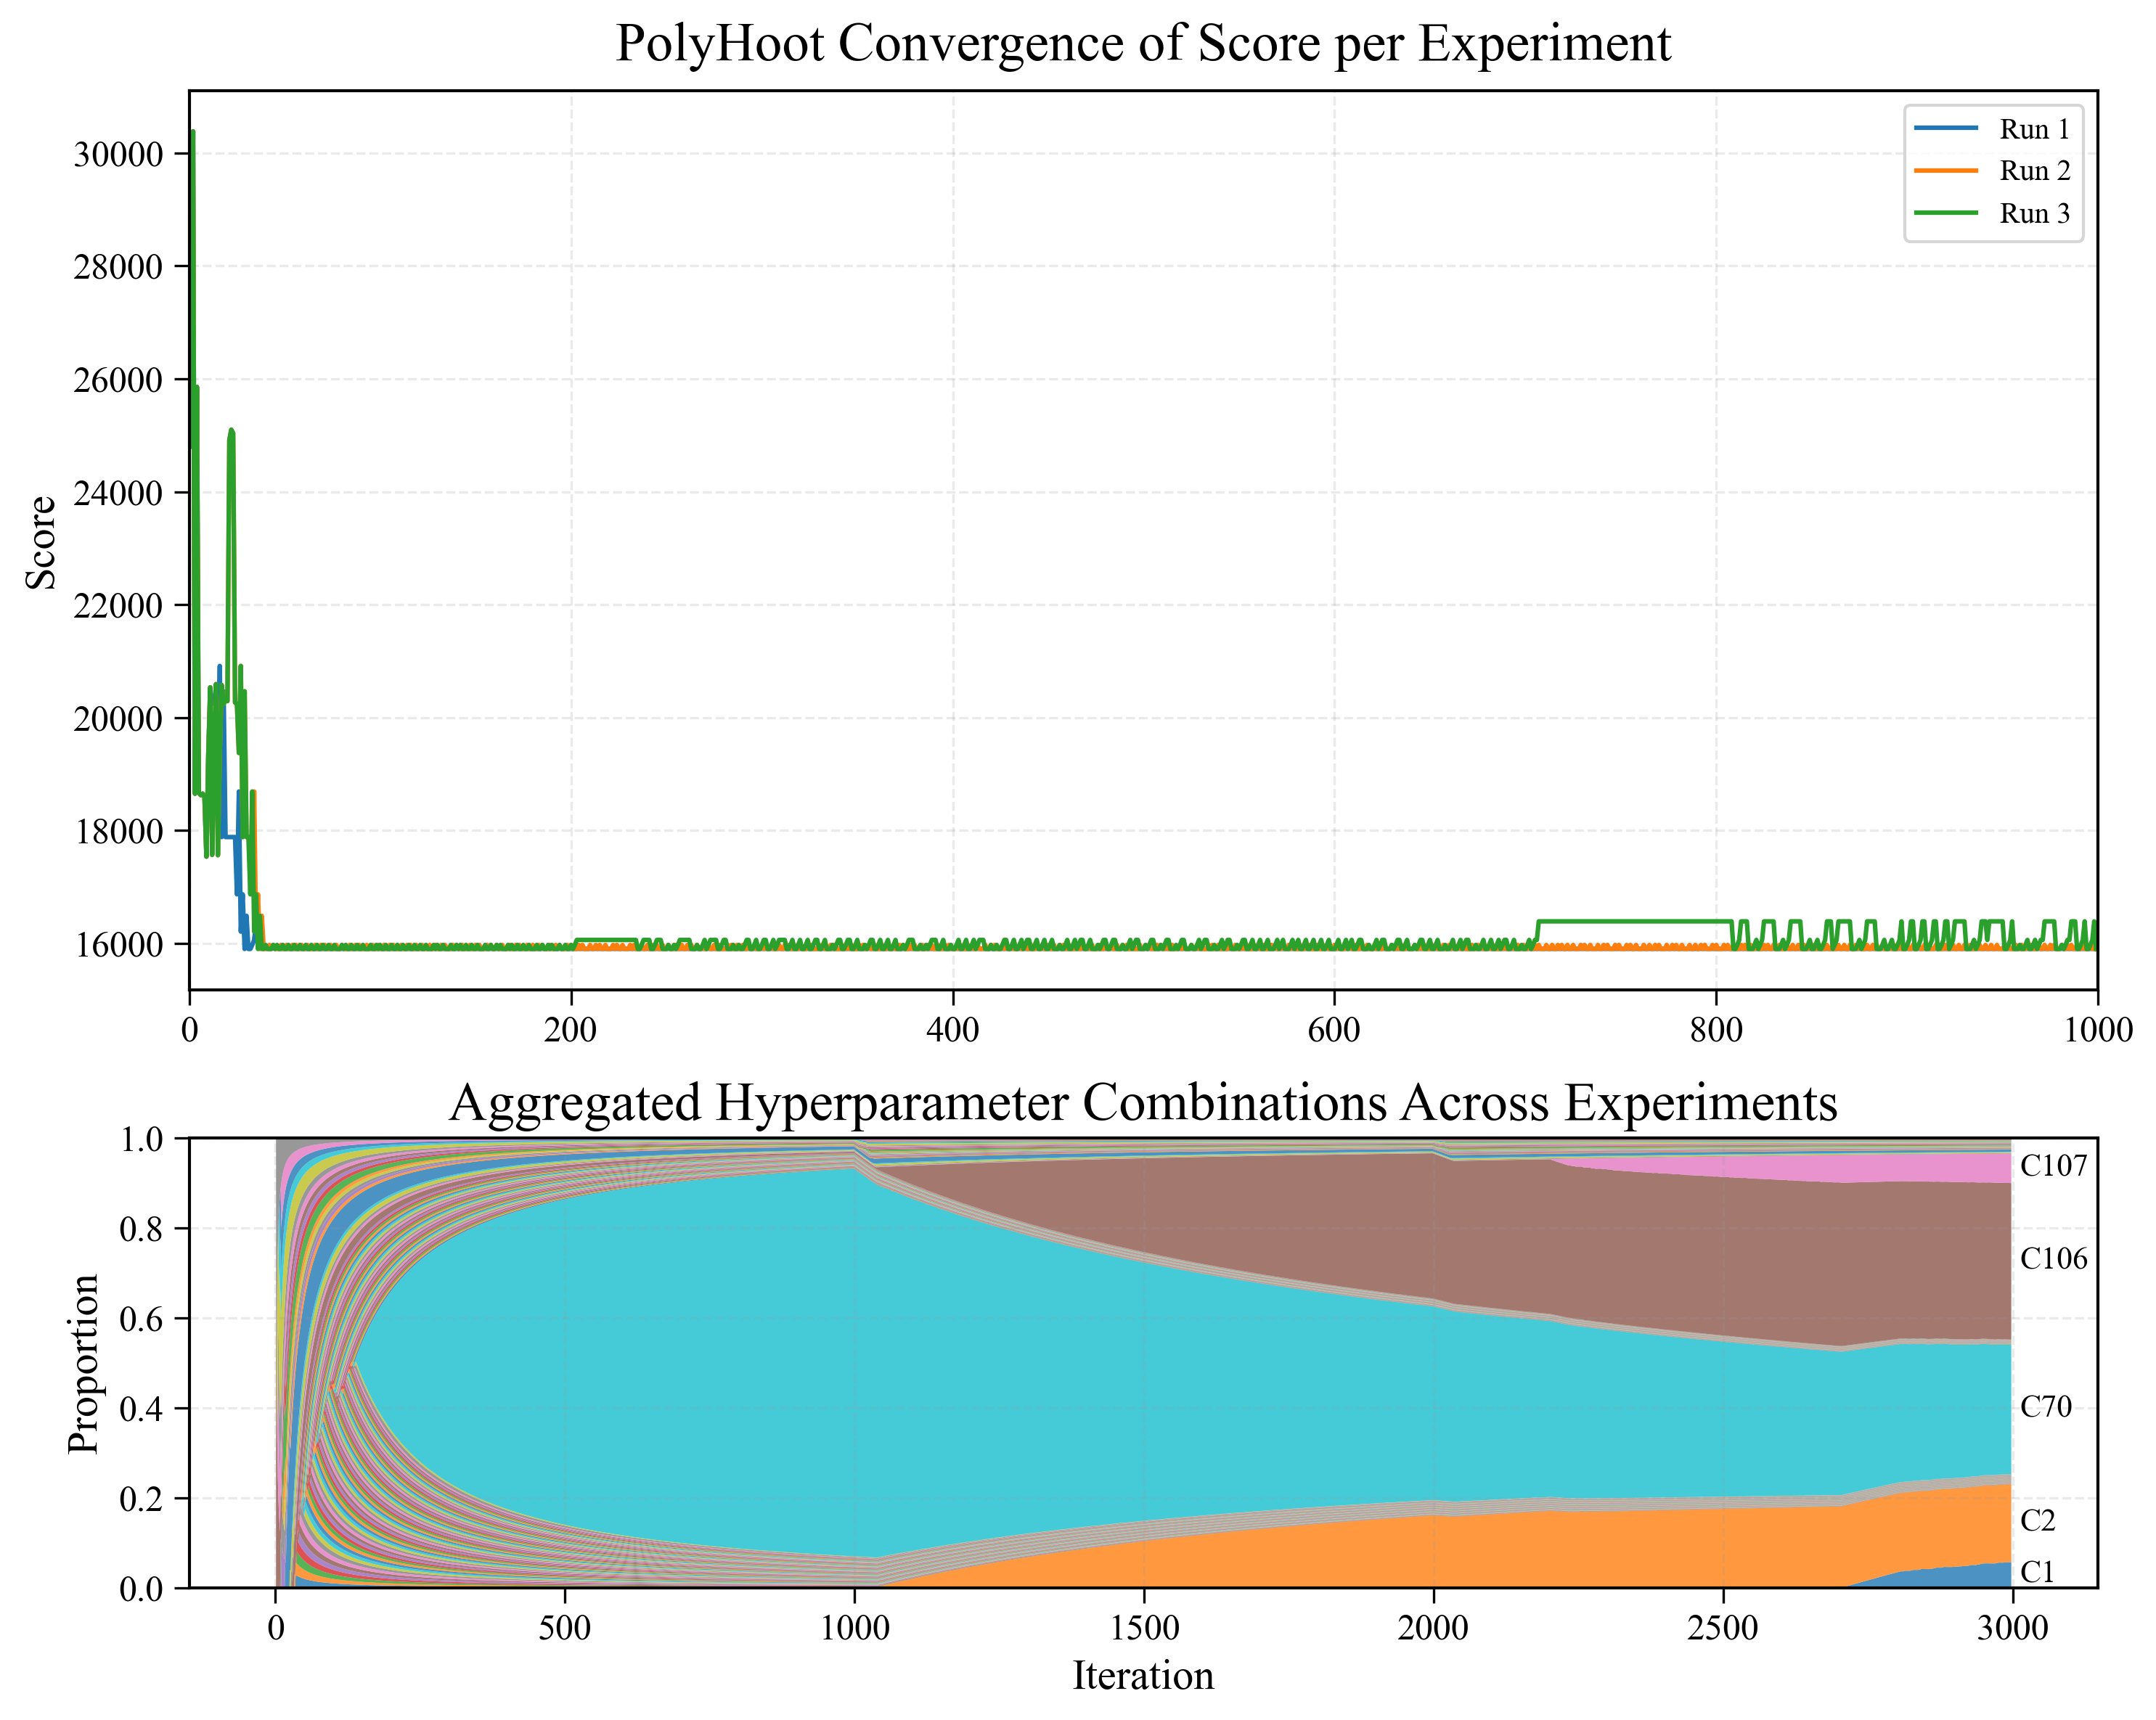

In [451]:
plot_multiple(
    full_df=df_full.dropna(),
    hyperparam_names=['scatter', 'min_strong_track_length', 'allowed_missed_modules'],
    config_col='config',
    title="PolyHoot Convergence of Score per Experiment",
    title_panel="Aggregated Hyperparameter Combinations Across Experiments",
    xlim=1000,
    annotate_threshold=0.05
)


Hyperparameter combinations with >5% share at final iteration:

C1: scatter=0.00390625, min_strong_track_length=5.0, allowed_missed_modules=4.0
C2: scatter=0.0078125, min_strong_track_length=5.0, allowed_missed_modules=4.0
C70: scatter=0.013234935690086012, min_strong_track_length=5.0, allowed_missed_modules=4.0
C106: scatter=0.015625, min_strong_track_length=5.0, allowed_missed_modules=4.0
C107: scatter=0.0234375, min_strong_track_length=5.0, allowed_missed_modules=4.0


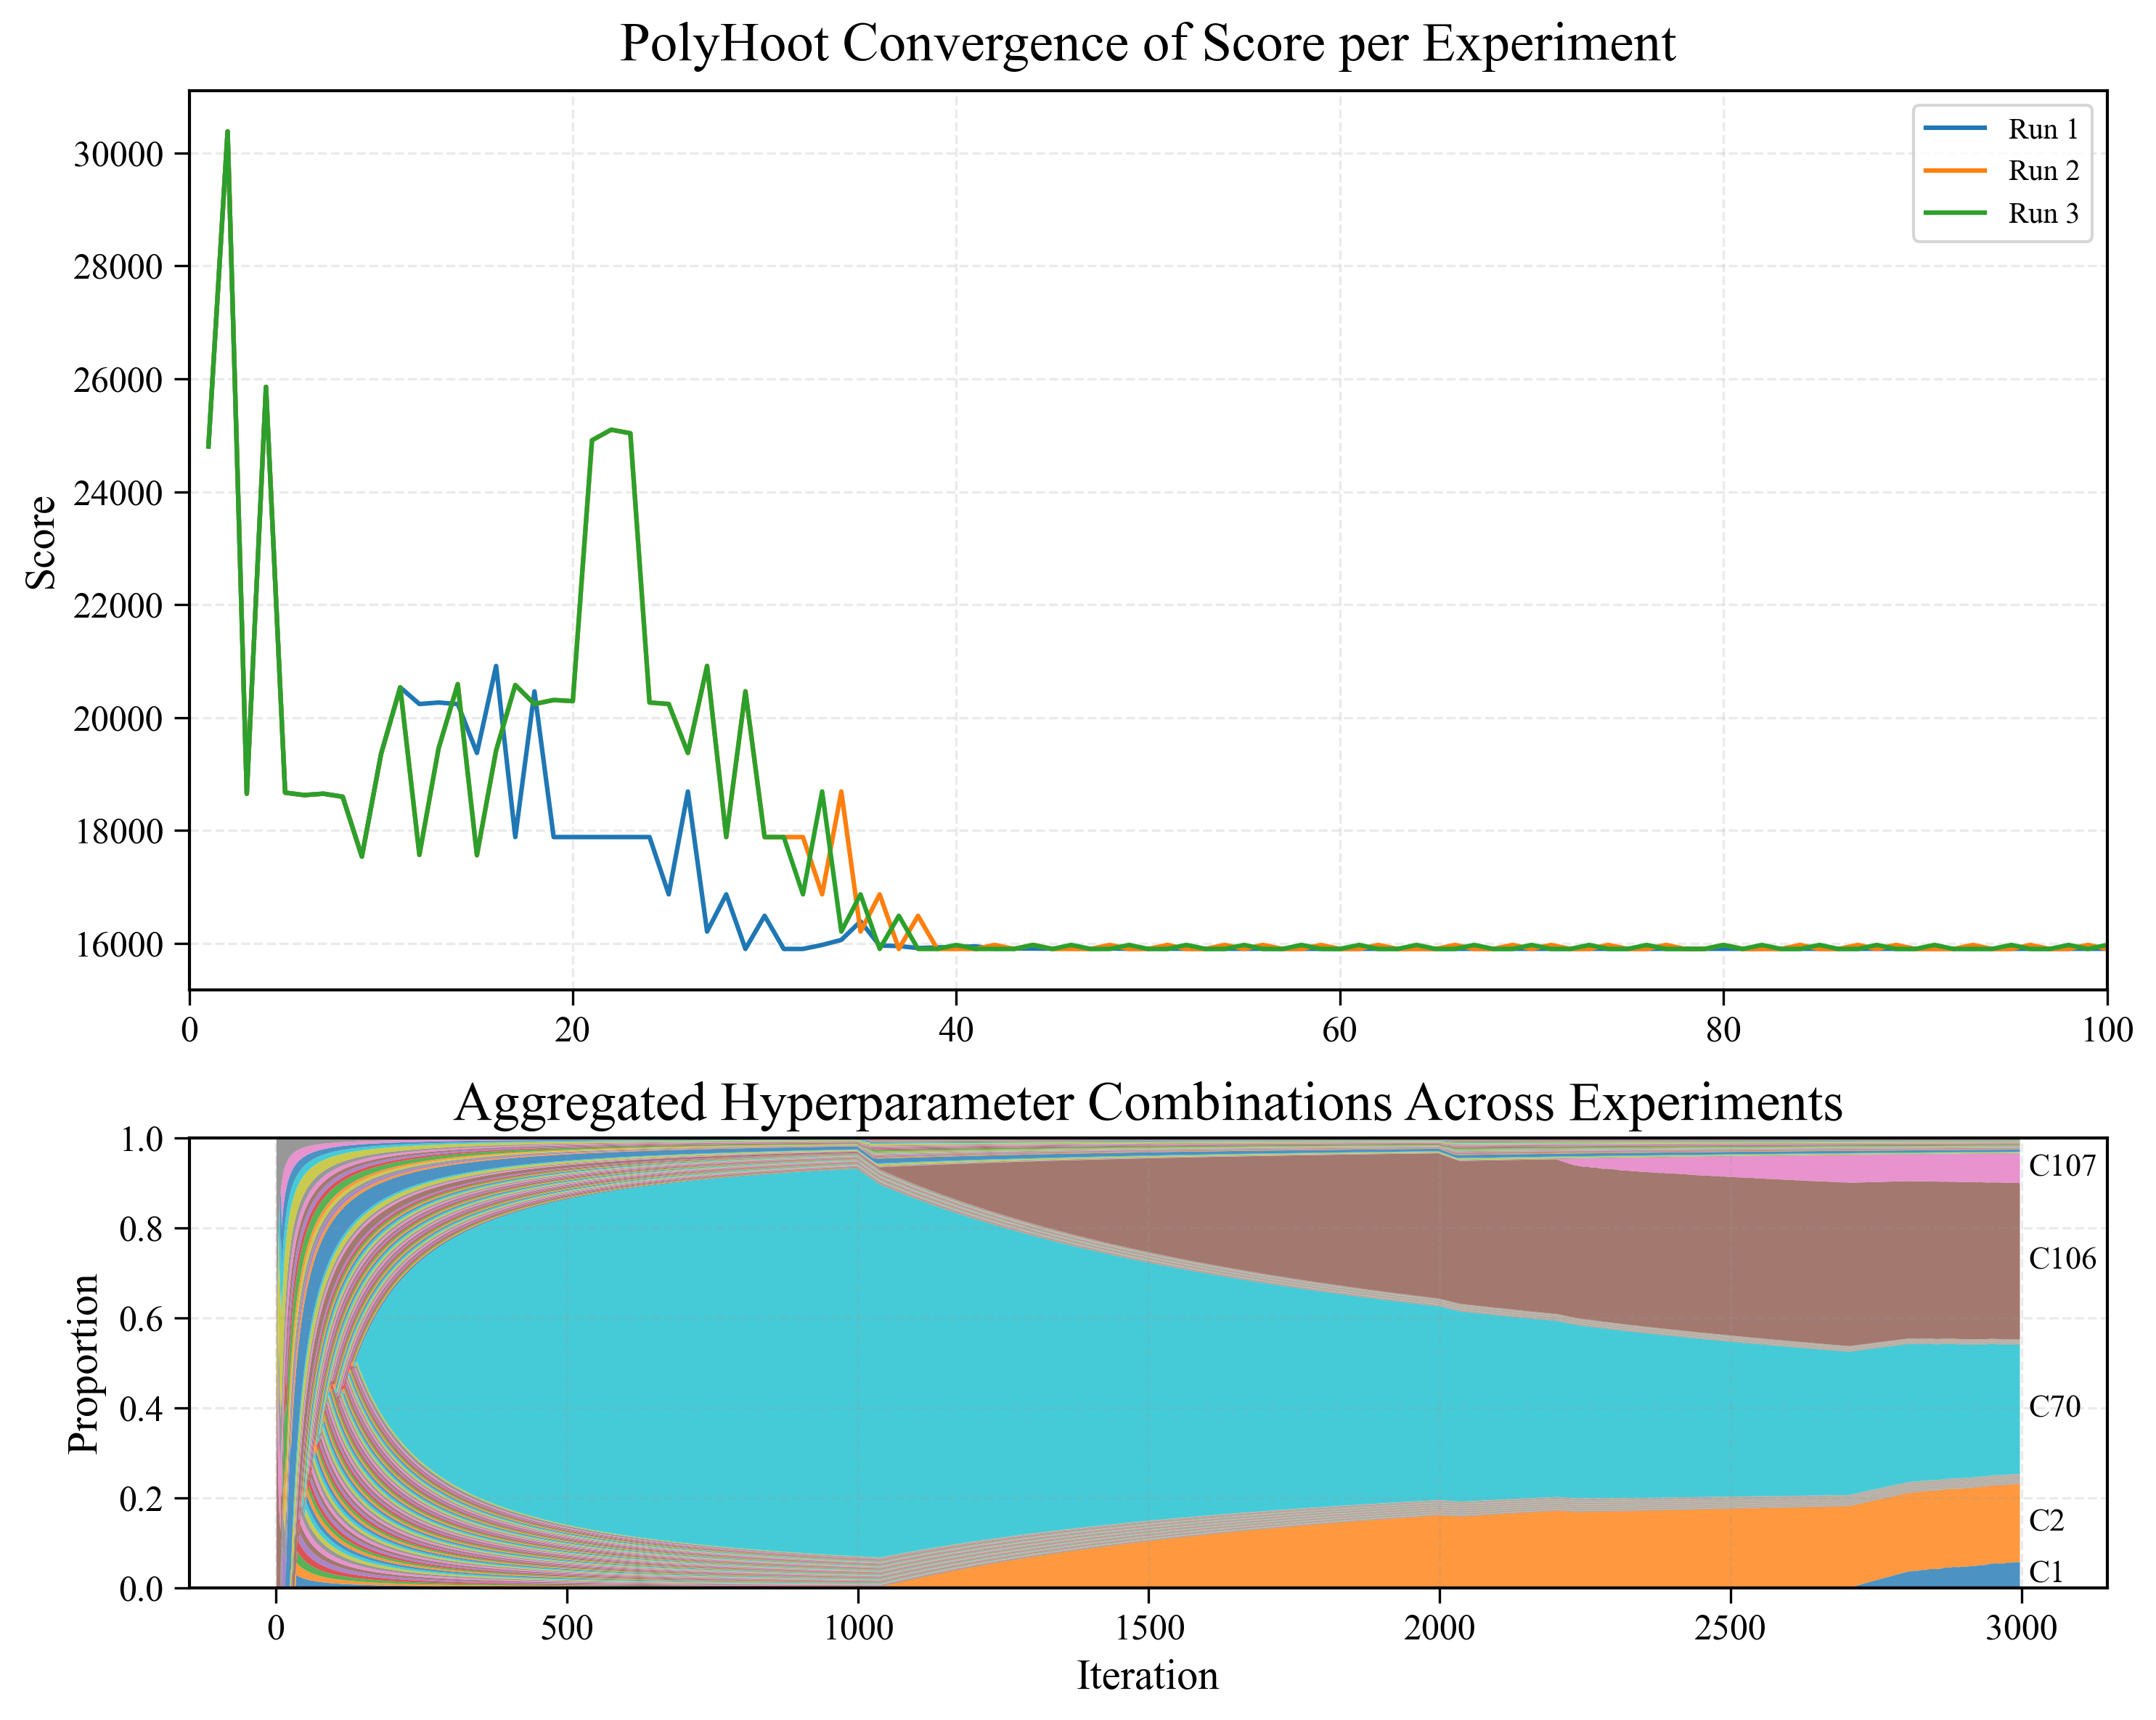

In [452]:
plot_multiple(
    full_df=df_full.dropna(),
    hyperparam_names=['scatter', 'min_strong_track_length', 'allowed_missed_modules'],
    config_col='config',
    title="PolyHoot Convergence of Score per Experiment",
    title_panel="Aggregated Hyperparameter Combinations Across Experiments",
    xlim=100,
    annotate_threshold=0.05
)

In [453]:
df_full.head()

,id,score,total_ghosts,overall_ghost_rate,event_avg_ghost_rate,clone_percentage,total_tracks,time,scatter,min_strong_track_length,allowed_missed_modules,config
0,84b36f0c-8bb0-4064-a0ae-fb43972a12d1,28490.674518,26605,46.706576,40.157170,2.706734,56962,0.833007,NaN,NaN,NaN,result_PolyHoot_ST_custom4.jsonl
1,cedb392c-bd97-4ecd-9ad2-8c6a41c63975,24802.695324,18750,37.810042,31.562295,2.992627,49590,0.333289,0.25,10.0,2.0,result_PolyHoot_ST_custom4.jsonl
2,ff1e8eef-a65a-4395-b968-2f0fbe164019,30382.829216,31004,51.039592,44.848324,2.611710,60745,0.303244,0.75,10.0,2.0,result_PolyHoot_ST_custom4.jsonl
3,31e92738-0cdc-49fa-9ae1-91cf312687ee,18651.643339,6577,17.634599,15.138502,2.833610,37296,0.291049,0.25,5.0,2.0,result_PolyHoot_ST_custom4.jsonl
4,be942bad-a3b1-4fce-bf4d-5d3170300a7e,25857.176391,20826,40.283957,33.850955,3.000756,51698,0.298998,0.25,15.0,2.0,result_PolyHoot_ST_custom4.jsonl


In [454]:
df9.drop(columns=["id", "scatter", "config", "min_strong_track_length", "allowed_missed_modules"]).head()

,score,total_ghosts,overall_ghost_rate,event_avg_ghost_rate,clone_percentage,total_tracks,time
0,28492.662957,26608,46.708563,40.158455,2.701388,56966,0.803111
1,24801.697025,18750,37.811567,31.564379,2.992019,49588,0.336778
2,30382.321746,31003,51.038786,44.847805,2.610859,60744,0.284972
3,18651.131458,6576,17.632390,15.137142,2.833665,37295,0.262451
4,25857.160857,20825,40.282023,33.848680,3.001364,51698,0.261132
